In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import models, layers


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp -r /content/drive/MyDrive/dataset /content/


In [ ]:
import os
os.listdir('/content/dataset')

['no-caries', 'caries']

In [ ]:
Image_size=256
Batch_size=32
Channel= 3
epochs=5

In [ ]:
dataset= tf.keras.preprocessing.image_dataset_from_directory(
    "dataset",
    shuffle=True,
    image_size=(Image_size, Image_size),
    batch_size=Batch_size
)

Found 1554 files belonging to 2 classes.


In [ ]:
class_names= dataset.class_names
class_names

['caries', 'no-caries']

In [ ]:
for image_batch, label_batch in dataset.take(1):
  print(image_batch.shape)
  print(label_batch.numpy())

(32, 256, 256, 3)
[0 0 0 0 0 1 0 1 0 0 0 0 0 0 1 0 0 0 0 1 1 0 0 0 0 1 0 1 1 1 0 0]


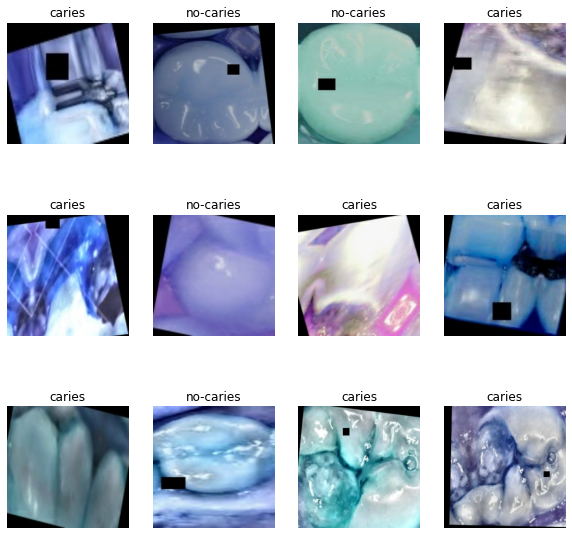

In [ ]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
  for i in range(12):
    ax=plt.subplot(3,4, i+1)
    image = image_batch[i].numpy().astype("uint8")
    plt.imshow(image)
    plt.title(class_names[label_batch[i]])
    plt.axis("off")
  

In [ ]:
train_size=0.8
len(dataset)*train_size

39.2

In [ ]:
test_ds=dataset.skip(39)
len(test_ds)

10

In [ ]:
val_size=0.1
len(dataset)*val_size

4.9

In [ ]:
test_ds=test_ds.skip(5)
len(test_ds)

5

In [ ]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=1000):

  ds_size= len(ds)

  if shuffle:
    ds= ds.shuffle(shuffle_size, seed=12)
  
  train_size=int(train_split * ds_size)
  val_size= int(val_split * ds_size)

  train_ds= ds.take(train_size)

  val_ds= ds.skip(train_size).take(val_size)
  test_ds= ds.skip(train_size).skip(val_size)

  return train_ds, val_ds, test_ds

In [ ]:
train_ds, val_ds, test_ds =get_dataset_partitions_tf(dataset)

In [ ]:
train_ds= train_ds.cache().shuffle(1000).prefetch(buffer_size= tf.data.AUTOTUNE)
val_ds= val_ds.cache().shuffle(1000).prefetch(buffer_size= tf.data.AUTOTUNE)
test_ds= test_ds.cache().shuffle(1000).prefetch(buffer_size= tf.data.AUTOTUNE)

In [ ]:
resize_and_rescale= tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(Image_size, Image_size),
    layers.experimental.preprocessing.Rescaling(1.0/255)

])

In [ ]:
data_augmentation= tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [ ]:
input_shape1=(Image_size, Image_size, Channel)
n_classes=3
vgg16=tf.keras.applications.VGG16(input_shape=input_shape1, include_top=False)
vgg16.trainable=False

In [ ]:
input_shape=(Batch_size,Image_size, Image_size, Channel)
modelVGG16= tf.keras.Sequential([
    resize_and_rescale,
    data_augmentation,
    vgg16,
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])
modelVGG16.build(input_shape=input_shape)

In [ ]:
modelVGG16.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 64)                2097216   
                                                                 
 dense_1 (Dense)             (None, 3)                 195       
                                                                 
Total params: 16,812,099
Trainable params: 2,097,411
N

In [ ]:
from keras.api._v2.keras.losses import SparseCategoricalCrossentropy
modelVGG16.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False, name='sparse_categorical_crossentropy'),
    metrics=['accuracy']
)

In [ ]:
history=modelVGG16.fit(
    train_ds,
    epochs=epochs,
    batch_size=Batch_size,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/5


39/39 [==============================] - 1002s 26s/step - loss: 0.7295 - accuracy: 0.7820 - val_loss: 0.3853 - val_accuracy: 0.8438
Epoch 2/5
39/39 [==============================] - 1041s 27s/step - loss: 0.3554 - accuracy: 0.8574 - val_loss: 0.3193 - val_accuracy: 0.8672
Epoch 3/5
39/39 [==============================] - 1042s 27s/step - loss: 0.2578 - accuracy: 0.8898 - val_loss: 0.2653 - val_accuracy: 0.8828
Epoch 4/5
39/39 [==============================] - 1048s 27s/step - loss: 0.2620 - accuracy: 0.8906 - val_loss: 0.2778 - val_accuracy: 0.9062
Epoch 5/5
39/39 [==============================] - 1042s 27s/step - loss: 0.2466 - accuracy: 0.8857 - val_loss: 0.3092 - val_accuracy: 0.8438


In [ ]:
scores16= modelVGG16.evaluate(test_ds)

6/6 [==============================] - 143s 23s/step - loss: 0.2672 - accuracy: 0.8646


In [ ]:
history.history['accuracy']


[0.7820097208023071,
 0.857374370098114,
 0.8897892832756042,
 0.8905996680259705,
 0.885737419128418]

In [ ]:
acc= history.history['accuracy']
val_acc= history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Loss')

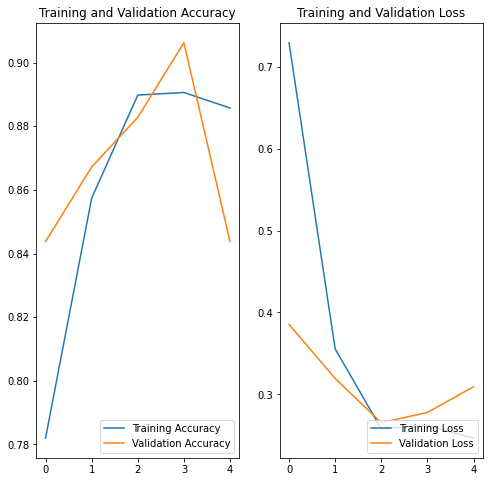

In [ ]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(epochs),acc, label='Training Accuracy')
plt.plot(range(epochs), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

#plt.figure(figsize=(8,8))
plt.subplot(1,2,2)
plt.plot(range(epochs),loss, label='Training Loss')
plt.plot(range(epochs), val_loss, label='Validation Loss')
plt.legend(loc='lower right')
plt.title('Training and Validation Loss')

In [ ]:
def predict(modelVGG16,img):
  img_array= tf.keras.preprocessing.image.img_to_array(image[i].numpy())
  img_array= tf.expand_dims(img_array, 0)

  prediction= modelVGG16.predict(img_array)

  predicted_class= class_names[np.argmax(prediction[0])]
  confidence=round(100*(np.max(prediction[0])),2)
  return predicted_class, confidence

1/1 [==============================] - 1s 878ms/step


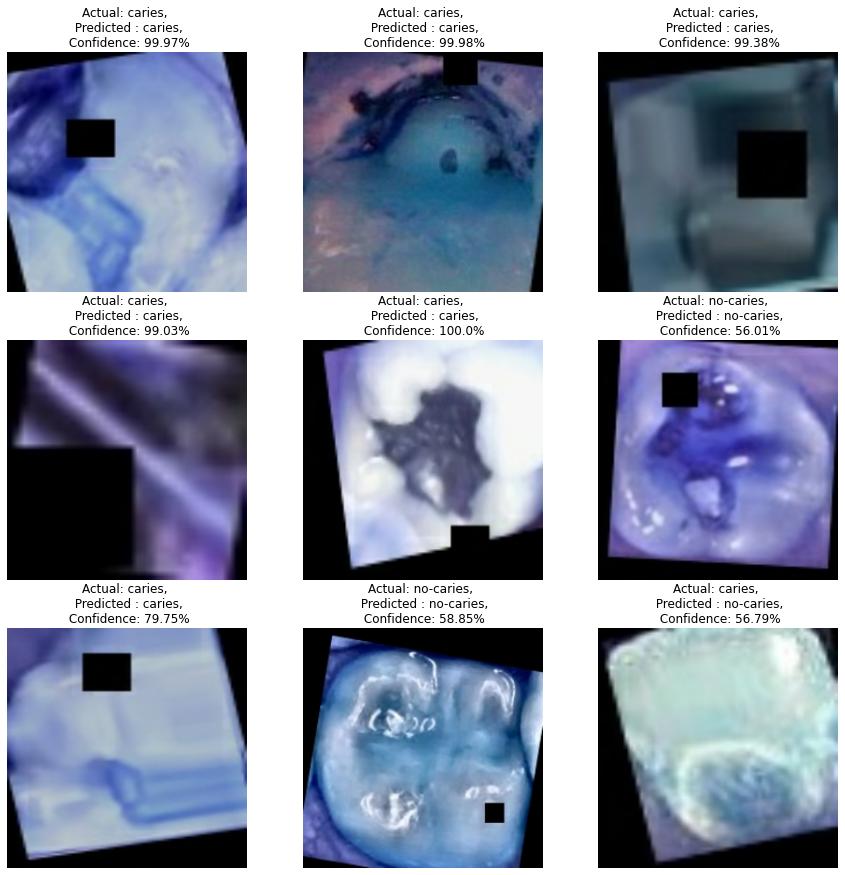

In [ ]:
plt.figure(figsize=(15,15))
for image, labels in test_ds.take(1):
  for i in range(9):
    ax= plt.subplot(3,3,i+1)
    image_=image_batch[i].numpy().astype("uint8")
    plt.imshow(image_)

    predicted_class, confidence= predict(modelVGG16, image[i].numpy())
    actual_class= class_names[labels[i]]

    plt.title(f"Actual: {actual_class}, \n Predicted : {predicted_class},\n Confidence: {confidence}%")
    plt.axis("off")

In [ ]:
from google.colab import auth
auth.authenticate_user()
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from oauth2client.client import GoogleCredentials

gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
modelVGG16.save('TeethDecayKerasPredcition_VGG16.h5')
file = drive.CreateFile({'title': 'TeethDecayKerasPredcition_VGG16.h5'})
file.Upload()

VGG_19 Implementation



In [ ]:
input_shape1=(Image_size, Image_size, Channel)
n_classes=3
vgg19=tf.keras.applications.VGG19(input_shape=input_shape1, include_top=False)
vgg19.trainable=False

80134624/80134624 [==============================] - 2s 0us/step


In [ ]:
input_shape=(Batch_size,Image_size, Image_size, Channel)
modelVGG19= tf.keras.Sequential([
    resize_and_rescale,
    data_augmentation,
    vgg19,
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])
modelVGG19.build(input_shape=input_shape)

In [ ]:
modelVGG19.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 vgg19 (Functional)          (None, 8, 8, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 64)                2097216   
                                                                 
 dense_1 (Dense)             (None, 3)                 195       
                                                                 
Total params: 22,121,795
Trainable params: 2,097,411
N

In [ ]:
from keras.api._v2.keras.losses import SparseCategoricalCrossentropy
modelVGG19.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False, name='sparse_categorical_crossentropy'),
    metrics=['accuracy']
)

In [ ]:
history_vgg19=modelVGG19.fit(
    train_ds,
    epochs=epochs,
    batch_size=Batch_size,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/5


39/39 [==============================] - 1307s 33s/step - loss: 0.8942 - accuracy: 0.7277 - val_loss: 0.3023 - val_accuracy: 0.8594
Epoch 2/5
39/39 [==============================] - 1298s 33s/step - loss: 0.3754 - accuracy: 0.8444 - val_loss: 0.3578 - val_accuracy: 0.8281
Epoch 3/5
39/39 [==============================] - 1292s 34s/step - loss: 0.3528 - accuracy: 0.8347 - val_loss: 0.3053 - val_accuracy: 0.8516
Epoch 4/5
39/39 [==============================] - 1258s 32s/step - loss: 0.3267 - accuracy: 0.8468 - val_loss: 0.2831 - val_accuracy: 0.8672
Epoch 5/5
39/39 [==============================] - 1291s 33s/step - loss: 0.2892 - accuracy: 0.8801 - val_loss: 0.3334 - val_accuracy: 0.8828


In [ ]:
scores19= modelVGG19.evaluate(test_ds)

6/6 [==============================] - 183s 29s/step - loss: 0.3551 - accuracy: 0.8281


In [ ]:
history_vgg19.history['accuracy']


[0.7277147769927979,
 0.8444084525108337,
 0.8346839547157288,
 0.8468395471572876,
 0.880064845085144]

In [ ]:
acc= history_vgg19.history['accuracy']
val_acc= history_vgg19.history['val_accuracy']
loss=history_vgg19.history['loss']
val_loss=history_vgg19.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Loss')

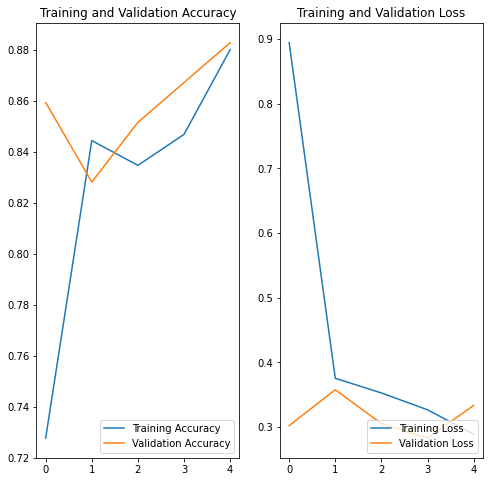

In [ ]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(epochs),acc, label='Training Accuracy')
plt.plot(range(epochs), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

#plt.figure(figsize=(8,8))
plt.subplot(1,2,2)
plt.plot(range(epochs),loss, label='Training Loss')
plt.plot(range(epochs), val_loss, label='Validation Loss')
plt.legend(loc='lower right')
plt.title('Training and Validation Loss')